1. Imports

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib as mpl
from matplotlib import pyplot as plt
from MALARIA2 import MALARIA
import localizerVgg
from scipy.ndimage.filters import maximum_filter, median_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from PIL import Image
from os import path
import utils

2. Parameters

In [3]:
NUM_CLASSES = 2 # Set to 2
img_id = 18 # Choose from 0 to 107
model_path = 'saved models/c-2_l2_b-0.0_e-10.pt'

3. Functions

In [4]:
def save_images(img, img_marked, map, gam, peak_map, peak_map_gt, path_save):
    img = Image.fromarray(img)
    img_marked = Image.fromarray(img_marked)
    path_img = path.join(path_save, f'image.bmp')
    path_img_marked = path.join(path_save, f'image_marked.bmp')
    img.save(path_img)
    img_marked.save(path_img_marked)
    for i in range(map.shape[0]):
        a = map[i]
        b = gam[i]
        ima = Image.fromarray(a)
        imb = Image.fromarray(b)
        peakI = Image.fromarray(peak_map[i]).convert("RGB")
        peakI_gt = Image.fromarray(peak_map_gt[i]).convert("RGB")
        peakI = peakI.resize((1600, 1200))
        peakI_gt = peakI_gt.resize((1600, 1200))

        path_ima = path.join(path_save, f'heatmap-class_{i}.bmp')
        path_imb = path.join(path_save, f'gt_heatmap-class_{i}.bmp')
        path_peak = path.join(path_save, f'peakmap-class_{i}_.bmp')
        path_peak_gt = path.join(path_save, f'peakmap-GT-class_{i}_.bmp')
        ima.save(path_ima)
        imb.save(path_imb)
        peakI.save(path_peak)
        peakI_gt.save(path_peak_gt)


def mark_peaks(img, peak_maps):
    image_marked = img.copy()
    # Mark centers of objects
    x_class_0, y_class_0 = np.where(peak_maps[0, 0])
    x_class_1, y_class_1 = np.where(peak_maps[0, 1])
    for i in range(0, x_class_0.shape[0]):
        for k in range(-5, 5):
            for j in range(-5, 5):
                image_marked[x_class_0[i]*8+k, y_class_0[i]*8+j, 0] = 255
                image_marked[x_class_0[i]*8+k, y_class_0[i]*8+j, 1:3] = 0
    for i in range(0, x_class_1.shape[0]):
        for k in range(-5, 5):
            for j in range(-5, 5):
                image_marked[x_class_1[i]*8+k, y_class_1[i]*8+j, 0] = 0
                image_marked[x_class_1[i]*8+k, y_class_1[i]*8+j, 1] = 255
                image_marked[x_class_1[i]*8+k, y_class_1[i]*8+j, 2] = 0
    return image_marked

4. Main

MALARIA dataset set=train number of classes=002  number of images=1208


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Model counted: [151   1].
GT: [148   1].


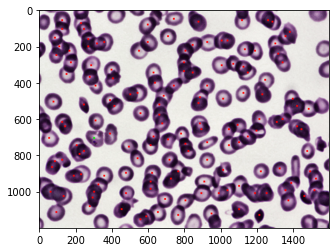

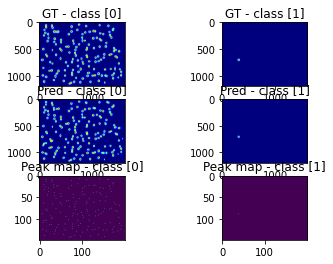

In [6]:
path_to_save = 'figures/paper'

cm_jet = mpl.cm.get_cmap('jet')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load pretrained model
dataset = MALARIA('', 'train', train=True, num_classes=NUM_CLASSES)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [1100, 108], generator=torch.Generator().manual_seed(42)) # [1100, 108]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

model = localizerVgg.localizervgg16(num_classes=test_dataset.dataset.get_number_classes(), pretrained=True)
state_dict = torch.load(model_path, map_location=torch.device(device))
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# thr = 0.5
# Set threshold as vector
if NUM_CLASSES == 2:
    thr = [0.5, 0.8]
elif NUM_CLASSES == 7:
    thr = [0.5, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
thr = np.array(thr).reshape(NUM_CLASSES, 1, 1)
with torch.no_grad():
    # Obtain image
    data, GAM, num_cells = test_dataset[img_id]
    data = data.unsqueeze(dim=0).to(device, dtype=torch.float)
    # GAM = torch.Tensor(GAM).unsqueeze(dim=0).to(device, dtype=torch.float)
    GAM = np.expand_dims(GAM, axis=0)

    MAP = model(data)
    # Create cMap for multi class
    cMap = MAP.data.cpu().numpy()
    cMap_min = cMap.min(axis=(2, 3)).reshape((cMap.shape[0], cMap.shape[1], 1, 1))
    cMap_max = cMap.max(axis=(2, 3)).reshape((cMap.shape[0], cMap.shape[1], 1, 1))
    cMap = (cMap - cMap_min) / (cMap_max - cMap_min)
    cMap[cMap < thr] = 0
    # Detect peaks in the predicted heat map:
    peakMAPs = utils.detect_peaks_multi_channels_batch(cMap)
    peakMAPs_gt = utils.detect_peaks_multi_channels_batch(GAM)

    # MAP & GAM shape is [B, C, H, W].

    pred_num_cells = np.sum(peakMAPs, axis=(2, 3))
    pred_num_cells_batch = np.sum(pred_num_cells, axis=0)

    MAP_norm = utils.normalize_map(MAP)
    # GAM_norm = GAM[0].data.cpu().contiguous().numpy().copy()
    GAM_norm = GAM[0]
    MAP_upsampled = utils.upsample_map(MAP_norm, dsr=8)
    GAM_upsampled = utils.upsample_map(GAM_norm, dsr=8)
    # Normalize image
    image = np.uint8(255*utils.normalize_image(data))

    # Mark centers of objects
    image_marked = mark_peaks(image, peakMAPs)


    peak_map = np.uint8(np.array(peakMAPs[0]) * 255)
    peak_map_gt = np.uint8(np.array(peakMAPs_gt[0]) * 255)

    plt.figure(1)
    plt.imshow(image_marked)
    num_plots = len(num_cells)
    plt.figure(2)
    for i in range(num_plots):
        plt.subplot(3, num_plots, i + 1)
        plt.imshow(GAM_upsampled[i])
        plt.title(f'GT - class [{i}]')
        plt.subplot(3, num_plots, i + num_plots + 1)
        plt.imshow(MAP_upsampled[i])
        plt.title(f'Pred - class [{i}]')
        plt.subplot(3, num_plots, i + 2*num_plots + 1)
        plt.imshow(peak_map[i])
        plt.title(f'Peak map - class [{i}]')

    save_images(image, image_marked, MAP_upsampled, GAM_upsampled, peak_map, peak_map_gt, path_to_save)

    print(f'Model counted: {pred_num_cells_batch.astype(int)}.')
    print(f'GT: {num_cells.data.cpu().numpy().astype(int)}.')
    plt.show()